In [1]:
# !git clone https://github.com/broccubali/DLG-Assignments.git

In [2]:
# !pip install torch_geometric

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import torch
import networkx as nx

In [ ]:
train_data = pd.read_csv('train_stock_data.csv')
train_data['Date'] = pd.to_datetime(train_data['Date'], format='%Y-%m-%d')
train_data.sort_values(['Ticker', 'Date'], inplace=True)

In [4]:
train_data

,Date,Ticker,Open,Open.1,Open.2,Open.3,Open.4,Open.5,Open.6,Open.7,...,Volume.10,Volume.11,Volume.12,Volume.13,Volume.14,Volume.15,Volume.16,Volume.17,Volume.18,Volume.19
0,2019-01-02,AAPL,36.944462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-03,AAPL,34.342203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-04,AAPL,34.473390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-07,AAPL,35.468021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-08,AAPL,35.673153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11083,2022-12-23,XOM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11539400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11084,2022-12-27,XOM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11962100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11085,2022-12-28,XOM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10702100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11086,2022-12-29,XOM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10534000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
validation_data = pd.read_csv('validation_stock_data.csv')
with open('hyperedges.json', 'r') as f:
    hyperedges = json.load(f)
with open('blind_test_cases.json', 'r') as f:
    test_cases = json.load(f)

In [6]:
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {validation_data.shape}")
print(f"Number of hyperedges: {len(hyperedges)}")
print(f"Number of test cases: {len(test_cases)}")
print("Training data columns:")
print(train_data.columns)

Training data shape: (20160, 102)
Validation data shape: (2000, 102)
Number of hyperedges: 8
Number of test cases: 120
Training data columns:
Index(['Date', 'Ticker', 'Open', 'Open.1', 'Open.2', 'Open.3', 'Open.4',
       'Open.5', 'Open.6', 'Open.7',
       ...
       'Volume.10', 'Volume.11', 'Volume.12', 'Volume.13', 'Volume.14',
       'Volume.15', 'Volume.16', 'Volume.17', 'Volume.18', 'Volume.19'],
      dtype='object', length=102)


In [7]:
print("Hyperedges structure:")
print(hyperedges)

print(type(hyperedges))

print("Available tickers in training data:", train_data['Ticker'].unique())

print("Test case example:")
test_cases[0]

Hyperedges structure:
{'Tech': ['AAPL', 'GOOGL', 'MSFT', 'AMZN'], 'Finance': ['JPM', 'BAC', 'C'], 'Healthcare': ['JNJ', 'PFE', 'MRK'], 'Energy': ['XOM', 'CVX'], 'Consumer': ['WMT', 'PG', 'KO'], 'Industrials': ['BA', 'CAT'], 'Communications': ['VZ', 'T'], 'Utilities': ['DUK']}
<class 'dict'>
Available tickers in training data: ['AAPL' 'AMZN' 'BA' 'BAC' 'C' 'CAT' 'CVX' 'DUK' 'GOOGL' 'JNJ' 'JPM' 'KO'
 'MRK' 'MSFT' 'PFE' 'PG' 'T' 'VZ' 'WMT' 'XOM']
Test case example:


{'ticker': 'GOOGL',
 'date': '2023-03-01',
 'predicted_open': None,
 'predicted_high': None,
 'predicted_low': None,
 'predicted_close': None,
 'predicted_volume': None,
 'eval_metric': 'MAPE'}

In [8]:
l = []
tickers = train_data['Ticker'].unique()
for ticker in tickers:
    data = train_data[train_data["Ticker"] == ticker]
    valid_cols = []
    for i in data.columns:
        if data[i].isna().sum() == 0:
            valid_cols.append(i)
    a = data[valid_cols].values
    for i in a:
        l.append(i)
df = pd.DataFrame(l, columns=["Date", "Ticker", "Open", "High", "Low", "Close", "Volume"])
df

,Date,Ticker,Open,High,Low,Close,Volume
0,2019-01-02,AAPL,36.944462,37.889005,36.787037,37.667179,148158800.0
1,2019-01-03,AAPL,34.342203,34.757230,33.869933,33.915253,365248800.0
2,2019-01-04,AAPL,34.473390,35.432244,34.299271,35.363071,234428400.0
3,2019-01-07,AAPL,35.468021,35.499030,34.800162,35.284359,219111200.0
4,2019-01-08,AAPL,35.673153,36.212212,35.425093,35.956993,164101200.0
...,...,...,...,...,...,...,...
20155,2022-12-23,XOM,99.121032,100.780001,99.074697,100.724396,11539400.0
20156,2022-12-27,XOM,101.271219,102.383381,100.863433,102.123878,11962100.0
20157,2022-12-28,XOM,101.864365,101.947773,100.001499,100.446358,10702100.0
20158,2022-12-29,XOM,100.084912,101.688276,100.084912,101.206337,10534000.0


In [10]:
from sklearn.preprocessing import RobustScaler 
scaler = RobustScaler()
scaler1 = RobustScaler()
feature_cols = ['Open', 'High', 'Low', 'Close']
df[feature_cols] = scaler.fit_transform(df[feature_cols])
df["Volume"] = scaler1.fit_transform(df[["Volume"]])
df

,Date,Ticker,Open,High,Low,Close,Volume,Return,Volatility,Momentum,Moving_Avg
0,2019-01-02,AAPL,-0.462705,-0.458112,-0.460747,-0.456032,5.101136,0.000000,0.000000,0.000000,0.000000
1,2019-01-03,AAPL,-0.493476,-0.494767,-0.495698,-0.500455,13.554442,-0.099607,0.000000,0.000000,0.000000
2,2019-01-04,AAPL,-0.491925,-0.486867,-0.490554,-0.483313,8.460403,0.042689,0.000000,0.000000,0.000000
3,2019-01-07,AAPL,-0.480164,-0.486085,-0.484553,-0.484245,7.863964,-0.002226,0.000000,0.000000,0.000000
4,2019-01-08,AAPL,-0.477738,-0.477738,-0.477065,-0.476281,5.721920,0.019063,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
20155,2022-12-23,XOM,0.272531,0.277970,0.285540,0.290567,-0.218712,0.026445,0.015932,0.038013,101.010784
20156,2022-12-27,XOM,0.297957,0.296736,0.306972,0.307137,-0.202252,0.013894,0.015044,0.047732,100.922739
20157,2022-12-28,XOM,0.304971,0.291638,0.296645,0.287275,-0.251315,-0.016426,0.015294,0.015840,100.768581
20158,2022-12-29,XOM,0.283929,0.288601,0.297644,0.296273,-0.257861,0.007566,0.015311,0.010550,100.616277


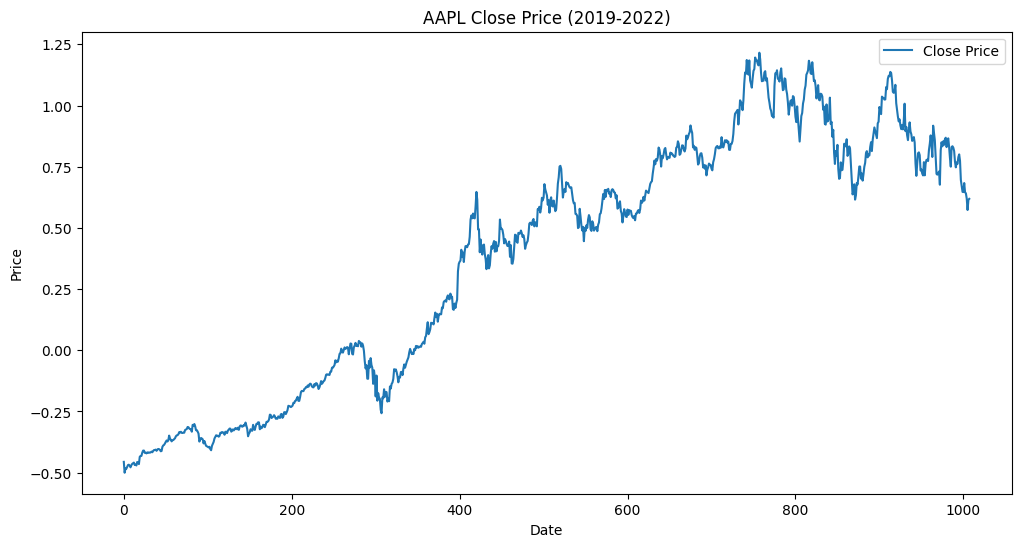

In [11]:
aapl = df[df["Ticker"] == "AAPL"]
plt.figure(figsize=(12, 6))
plt.plot(aapl.index, aapl['Close'], label='Close Price')
plt.title('AAPL Close Price (2019-2022)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [12]:
stocks = ['AAPL', 'AMZN', 'BA', 'BAC', 'C', 'CAT', 'CVX', 'DUK', 'GOOGL', 'JNJ', 'JPM' ,'KO', 'MRK', 'MSFT', 'PFE', 'PG', 'T', 'VZ', 'WMT', 'XOM']

ticker_to_idx = {ticker: idx for idx, ticker in enumerate(sorted(tickers))}
print("Ticker to index mapping:", ticker_to_idx)

Ticker to index mapping: {'AAPL': 0, 'AMZN': 1, 'BA': 2, 'BAC': 3, 'C': 4, 'CAT': 5, 'CVX': 6, 'DUK': 7, 'GOOGL': 8, 'JNJ': 9, 'JPM': 10, 'KO': 11, 'MRK': 12, 'MSFT': 13, 'PFE': 14, 'PG': 15, 'T': 16, 'VZ': 17, 'WMT': 18, 'XOM': 19}


In [13]:
hyperedge_indices = []
for he_name, ticker in hyperedges.items():
    indices = [ticker_to_idx[t] for t in ticker]
    print(f"Hyperedge '{he_name}': {ticker} -> {indices}")
    hyperedge_indices.append(indices)

Hyperedge 'Tech': ['AAPL', 'GOOGL', 'MSFT', 'AMZN'] -> [0, 8, 13, 1]
Hyperedge 'Finance': ['JPM', 'BAC', 'C'] -> [10, 3, 4]
Hyperedge 'Healthcare': ['JNJ', 'PFE', 'MRK'] -> [9, 14, 12]
Hyperedge 'Energy': ['XOM', 'CVX'] -> [19, 6]
Hyperedge 'Consumer': ['WMT', 'PG', 'KO'] -> [18, 15, 11]
Hyperedge 'Industrials': ['BA', 'CAT'] -> [2, 5]
Hyperedge 'Communications': ['VZ', 'T'] -> [17, 16]
Hyperedge 'Utilities': ['DUK'] -> [7]


In [14]:
hyperedge_indices

[[0, 8, 13, 1],
 [10, 3, 4],
 [9, 14, 12],
 [19, 6],
 [18, 15, 11],
 [2, 5],
 [17, 16],
 [7]]

## clique representation

In [15]:
adj_matrix = [[0 for i in range(20)] for j in range(20)]
for hyperedge in hyperedge_indices:
    for i in range(len(hyperedge)):
        for j in range(i+1, len(hyperedge)):
            adj_matrix[hyperedge[i]][hyperedge[j]] = 1
            adj_matrix[hyperedge[j]][hyperedge[i]] = 1
adj_matrix = np.array(adj_matrix)
adj_matrix

array([[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

In [16]:
import torch
edge_index = torch.tensor(np.array(np.nonzero(adj_matrix)), dtype=torch.long)
edge_index

tensor([[ 0,  0,  0,  1,  1,  1,  2,  3,  3,  4,  4,  5,  6,  8,  8,  8,  9,  9,
         10, 10, 11, 11, 12, 12, 13, 13, 13, 14, 14, 15, 15, 16, 17, 18, 18, 19],
        [ 1,  8, 13,  0,  8, 13,  5,  4, 10,  3, 10,  2, 19,  0,  1, 13, 12, 14,
          3,  4, 15, 18,  9, 14,  0,  1,  8,  9, 12, 11, 18, 17, 16, 11, 15,  6]])

In [ ]:
def get_features_for_date(df, date, tickers, feature_cols):
    day_df = df[df['Date'] == date].set_index('Ticker')
    day_df = day_df.reindex(tickers)
    x = day_df[feature_cols].fillna(0).values
    y = day_df[['Open', 'High', 'Low', 'Close', 'Volume']].fillna(0).values
    return torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)

target_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
dates = sorted(df['Date'].unique())
graph_snapshots = []
tickers = sorted(df['Ticker'].unique())
for date in dates:
    x_t, y_t = get_features_for_date(df, date, tickers, target_cols)
    graph_snapshots.append((x_t, y_t))

In [18]:
# import torch
# from torch_geometric.data import Data

# def create_sliding_window_graphs(df, tickers, feature_cols, target_cols, window_size, edge_index):
#     df = df.sort_values(['Ticker', 'Date']).reset_index(drop=True)
#     all_dates = sorted(df['Date'].unique())
#     graphs = []

#     for current_date in all_dates[window_size:]:
#         x_list, y_list = [], []

#         for ticker in tickers:
#             ticker_df = df[df['Ticker'] == ticker].reset_index(drop=True)
#             date_idx = ticker_df[ticker_df['Date'] == current_date].index

#             if len(date_idx) == 0 or date_idx[0] < window_size:
#                 x = torch.zeros((window_size, len(feature_cols)))
#                 y = torch.zeros(len(target_cols))
#             else:
#                 idx = date_idx[0]
#                 window = ticker_df.iloc[idx - window_size:idx][feature_cols].values
#                 x = torch.tensor(window, dtype=torch.float32)

#                 target = ticker_df.iloc[idx][target_cols].astype(float).values
#                 y = torch.tensor(target, dtype=torch.float32)

#             x_list.append(x)
#             y_list.append(y)

#         x_tensor = torch.stack(x_list)             
#         y_tensor = torch.stack(y_list)              
#         graph = Data(x=x_tensor, edge_index=edge_index, y=y_tensor)
#         graphs.append(graph)

#     return graphs

In [19]:
# target_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# graph_snapshots = create_sliding_window_graphs(
#     df=df,
#     tickers=tickers,
#     feature_cols=features,
#     target_cols=target_cols,
#     window_size=30,
#     edge_index=edge_index  
# )

In [20]:
from torch_geometric.data import Data

graphs = []

for x_t, y_t in graph_snapshots:
    graph = Data(x=x_t, edge_index=edge_index, y=y_t)
    graphs.append(graph)

In [21]:
graphs[0]

Data(x=[20, 9], edge_index=[2, 36], y=[20, 5])

In [22]:
val_data = pd.read_csv('validation_stock_data.csv')
val_data['Date'] = pd.to_datetime(val_data['Date'], format='%Y-%m-%d')
val_data.sort_values(['Ticker', 'Date'], inplace=True)
l = []
val_tickers = sorted(val_data['Ticker'].unique())
for ticker in val_tickers:
    data = val_data[val_data["Ticker"] == ticker]
    valid_cols = []
    for i in data.columns:
        if data[i].isna().sum() == 0:
            valid_cols.append(i)
    a = data[valid_cols].values
    for i in a:
        l.append(i)
df1 = pd.DataFrame(l, columns=["Date", "Ticker", "Open", "High", "Low", "Close", "Volume"])
df1

,Date,Ticker,Open,High,Low,Close,Volume
0,2023-01-03,AAPL,128.782649,129.395518,122.742873,123.632530,112117500.0
1,2023-01-04,AAPL,125.431607,127.181268,123.642412,124.907700,89113600.0
2,2023-01-05,AAPL,125.668857,126.301500,123.326101,123.583107,80962700.0
3,2023-01-06,AAPL,124.561702,128.792501,123.454572,128.130203,87754700.0
4,2023-01-09,AAPL,128.970458,131.876670,128.397123,128.654129,70790800.0
...,...,...,...,...,...,...,...
1995,2023-12-22,XOM,98.058076,98.661898,97.588442,97.674706,12921800.0
1996,2023-12-26,XOM,98.470205,98.748153,97.875976,97.895142,16835100.0
1997,2023-12-27,XOM,97.799294,98.288101,97.128381,97.435089,14558800.0
1998,2023-12-28,XOM,97.176310,97.387168,95.968673,96.026184,16329300.0


In [24]:
df2 = df1[feature_cols].copy()
df1[feature_cols] = scaler.transform(df1[feature_cols])
df1["Volume"] = scaler1.transform(df1[["Volume"]])
df1

,Date,Ticker,Open,High,Low,Close,Volume,Return,Volatility,Momentum,Moving_Avg
0,2023-01-03,AAPL,0.623278,0.612889,0.569116,0.561800,3.697717,0.000000,0.000000,0.000000,0.000000
1,2023-01-04,AAPL,0.583652,0.586973,0.579894,0.576898,2.801964,0.010314,0.000000,0.000000,0.000000
2,2023-01-05,AAPL,0.586458,0.576676,0.576104,0.561215,2.484575,-0.010605,0.000000,0.000000,0.000000
3,2023-01-06,AAPL,0.573366,0.605831,0.577643,0.615052,2.749050,0.036794,0.000000,0.000000,0.000000
4,2023-01-09,AAPL,0.625499,0.641928,0.636862,0.621256,2.088489,0.004089,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
1995,2023-12-22,XOM,0.259961,0.253179,0.267733,0.254458,-0.164882,0.001769,0.011277,0.010010,97.892264
1996,2023-12-26,XOM,0.264835,0.254189,0.271178,0.257068,-0.012501,0.002257,0.011193,0.004820,97.870862
1997,2023-12-27,XOM,0.256901,0.248805,0.262221,0.251621,-0.101139,-0.004699,0.011037,-0.012914,97.799618
1998,2023-12-28,XOM,0.249535,0.238260,0.248326,0.234940,-0.032197,-0.014460,0.011282,-0.010665,97.668631


In [ ]:
dates = sorted(df1['Date'].unique())
val_graph_snapshots = []

for date in dates:
    x_t, y_t = get_features_for_date(df1, date, tickers, target_cols)
    val_graph_snapshots.append((x_t, y_t))

In [26]:
# val_graph_snapshots = create_sliding_window_graphs(
#     df=df1,
#     tickers=tickers,
#     feature_cols=features,
#     target_cols=target_cols,
#     window_size=30,
#     edge_index=edge_index  
# )
# val_graph_snapshots[0]

In [27]:
val_graphs = []

for x_t, y_t in val_graph_snapshots:
    graph = Data(x=x_t, edge_index=edge_index, y=y_t)
    val_graphs.append(graph)
val_graphs[0]

Data(x=[20, 9], edge_index=[2, 36], y=[20, 5])

In [28]:
from torch_geometric.nn import GATConv
import torch.nn as nn
import torch.nn.functional as F

class StockGAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=5, heads=32, dropout=0.3):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(hidden_channels * heads)

        self.gat2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(hidden_channels * heads)

        self.gat3 = GATConv(hidden_channels * heads, hidden_channels, heads=1)
        self.norm3 = nn.LayerNorm(hidden_channels)

        self.regressor = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels // 2, out_channels)
        )
        self.scale_factor = nn.Parameter(torch.ones(out_channels))
        self.scale_bias = nn.Parameter(torch.zeros(out_channels))


    def forward(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))
        x = self.norm1(x)

        x = F.elu(self.gat2(x, edge_index))
        x = self.norm2(x)

        x = F.elu(self.gat3(x, edge_index))
        x = self.norm3(x)

        out = self.regressor(x)
        return out * self.scale_factor + self.scale_bias

In [32]:
# model = HybridTemporalGAT(
#     input_dim=len(features),
#     lstm_hidden=32,
#     gat_hidden=32,
#     out_channels=len(target_cols),
#     heads=16,
#     dropout=0.3,
#     window_size=30
# )

model = StockGAT(
    in_channels=len(features),
    hidden_channels=128,
    out_channels=5,
    heads=32,
    dropout=0.3
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
loss_fn = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-5)

In [33]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(graphs, batch_size=64, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=64, shuffle=False)

In [34]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
edge_index = edge_index.to(device)
epochs = 100
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader, desc=f"[Epoch {epoch+1}] Training", leave=False):
        batch = batch.to(device)

        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"[Epoch {epoch+1}] Validation", leave=False):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            loss = loss_fn(out, batch.y)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


[Epoch 1] Training:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.8133 | Val Loss: 0.2777


Epoch 2 | Train Loss: 0.7488 | Val Loss: 0.2744


Epoch 3 | Train Loss: 0.6663 | Val Loss: 0.3065


Epoch 4 | Train Loss: 0.5813 | Val Loss: 0.3372


Epoch 5 | Train Loss: 0.5272 | Val Loss: 0.3188


Epoch 6 | Train Loss: 0.5048 | Val Loss: 0.3398


Epoch 7 | Train Loss: 0.4642 | Val Loss: 0.3410


Epoch 8 | Train Loss: 0.4410 | Val Loss: 0.3617


Epoch 9 | Train Loss: 0.4275 | Val Loss: 0.3545


Epoch 10 | Train Loss: 0.4126 | Val Loss: 0.3508


Epoch 11 | Train Loss: 0.4091 | Val Loss: 0.3569


Epoch 12 | Train Loss: 0.4032 | Val Loss: 0.3594


Epoch 13 | Train Loss: 0.3996 | Val Loss: 0.3631


Epoch 14 | Train Loss: 0.3981 | Val Loss: 0.3779


Epoch 15 | Train Loss: 0.3982 | Val Loss: 0.3634


Epoch 16 | Train Loss: 0.3955 | Val Loss: 0.3610


Epoch 17 | Train Loss: 0.3938 | Val Loss: 0.3678


Epoch 18 | Train Loss: 0.3943 | Val Loss: 0.3759


Epoch 19 | Train Loss: 0.3893 | Val Loss: 0.3697


Epoch 20 | Train Loss: 0.3897 | Val Loss: 0.3775


Epoch 21 | Train Loss: 0.3873 | Val Loss: 0.3759


Epoch 22 | Train Loss: 0.3898 | Val Loss: 0.3833


Epoch 23 | Train Loss: 0.3886 | Val Loss: 0.3809


Epoch 24 | Train Loss: 0.3903 | Val Loss: 0.3864


Epoch 25 | Train Loss: 0.3869 | Val Loss: 0.3798


Epoch 26 | Train Loss: 0.3876 | Val Loss: 0.3801


Epoch 27 | Train Loss: 0.3862 | Val Loss: 0.3790


Epoch 28 | Train Loss: 0.3862 | Val Loss: 0.3819


Epoch 29 | Train Loss: 0.3854 | Val Loss: 0.3835


Epoch 30 | Train Loss: 0.3845 | Val Loss: 0.3796


Epoch 31 | Train Loss: 0.3855 | Val Loss: 0.3816


Epoch 32 | Train Loss: 0.3851 | Val Loss: 0.3855


Epoch 33 | Train Loss: 0.3852 | Val Loss: 0.3825


Epoch 34 | Train Loss: 0.3855 | Val Loss: 0.3808


Epoch 35 | Train Loss: 0.3836 | Val Loss: 0.3805


Epoch 36 | Train Loss: 0.3851 | Val Loss: 0.3828


Epoch 37 | Train Loss: 0.3830 | Val Loss: 0.3908


Epoch 38 | Train Loss: 0.3812 | Val Loss: 0.3906


Epoch 39 | Train Loss: 0.3836 | Val Loss: 0.3844


Epoch 40 | Train Loss: 0.3808 | Val Loss: 0.3852


Epoch 41 | Train Loss: 0.3815 | Val Loss: 0.3885


Epoch 42 | Train Loss: 0.3822 | Val Loss: 0.3899


Epoch 43 | Train Loss: 0.3796 | Val Loss: 0.3929


Epoch 44 | Train Loss: 0.3804 | Val Loss: 0.3874


Epoch 45 | Train Loss: 0.3793 | Val Loss: 0.3936


Epoch 46 | Train Loss: 0.3806 | Val Loss: 0.3914


Epoch 47 | Train Loss: 0.3806 | Val Loss: 0.3902


Epoch 48 | Train Loss: 0.3791 | Val Loss: 0.3909


Epoch 49 | Train Loss: 0.3812 | Val Loss: 0.3940


Epoch 50 | Train Loss: 0.3811 | Val Loss: 0.3853


Epoch 51 | Train Loss: 0.3774 | Val Loss: 0.3993


Epoch 52 | Train Loss: 0.3796 | Val Loss: 0.3992


Epoch 53 | Train Loss: 0.3767 | Val Loss: 0.3952


Epoch 54 | Train Loss: 0.3762 | Val Loss: 0.3966


Epoch 55 | Train Loss: 0.3783 | Val Loss: 0.3959


Epoch 56 | Train Loss: 0.3800 | Val Loss: 0.3993


Epoch 57 | Train Loss: 0.3745 | Val Loss: 0.3982


Epoch 58 | Train Loss: 0.3764 | Val Loss: 0.4008


Epoch 59 | Train Loss: 0.3762 | Val Loss: 0.4054


Epoch 60 | Train Loss: 0.3752 | Val Loss: 0.4022


Epoch 61 | Train Loss: 0.3758 | Val Loss: 0.3975


Epoch 62 | Train Loss: 0.3734 | Val Loss: 0.4040


Epoch 63 | Train Loss: 0.3743 | Val Loss: 0.4089


Epoch 64 | Train Loss: 0.3754 | Val Loss: 0.4096


Epoch 65 | Train Loss: 0.3747 | Val Loss: 0.4091


Epoch 66 | Train Loss: 0.3758 | Val Loss: 0.4077


Epoch 67 | Train Loss: 0.3740 | Val Loss: 0.4092


Epoch 68 | Train Loss: 0.3752 | Val Loss: 0.4153


Epoch 69 | Train Loss: 0.3751 | Val Loss: 0.4190


Epoch 70 | Train Loss: 0.3749 | Val Loss: 0.4121


Epoch 71 | Train Loss: 0.3732 | Val Loss: 0.4100


Epoch 72 | Train Loss: 0.3746 | Val Loss: 0.4159


Epoch 73 | Train Loss: 0.3763 | Val Loss: 0.4116


Epoch 74 | Train Loss: 0.3753 | Val Loss: 0.4168


Epoch 75 | Train Loss: 0.3715 | Val Loss: 0.4049


Epoch 76 | Train Loss: 0.3752 | Val Loss: 0.4120


Epoch 77 | Train Loss: 0.3701 | Val Loss: 0.4164


Epoch 78 | Train Loss: 0.3753 | Val Loss: 0.4128


Epoch 79 | Train Loss: 0.3701 | Val Loss: 0.4136


Epoch 80 | Train Loss: 0.3728 | Val Loss: 0.4187


Epoch 81 | Train Loss: 0.3734 | Val Loss: 0.4196


Epoch 82 | Train Loss: 0.3739 | Val Loss: 0.4214


Epoch 83 | Train Loss: 0.3722 | Val Loss: 0.4324


Epoch 84 | Train Loss: 0.3741 | Val Loss: 0.4207


Epoch 85 | Train Loss: 0.3736 | Val Loss: 0.4195


Epoch 86 | Train Loss: 0.3717 | Val Loss: 0.4274


Epoch 87 | Train Loss: 0.3714 | Val Loss: 0.4178


Epoch 88 | Train Loss: 0.3710 | Val Loss: 0.4227


Epoch 89 | Train Loss: 0.3709 | Val Loss: 0.4149


Epoch 90 | Train Loss: 0.3715 | Val Loss: 0.4280


Epoch 91 | Train Loss: 0.3694 | Val Loss: 0.4307


Epoch 92 | Train Loss: 0.3716 | Val Loss: 0.4208


Epoch 93 | Train Loss: 0.3702 | Val Loss: 0.4309


Epoch 94 | Train Loss: 0.3719 | Val Loss: 0.4211


Epoch 95 | Train Loss: 0.3733 | Val Loss: 0.4312


Epoch 96 | Train Loss: 0.3707 | Val Loss: 0.4323


Epoch 97 | Train Loss: 0.3725 | Val Loss: 0.4328


Epoch 98 | Train Loss: 0.3717 | Val Loss: 0.4258


Epoch 99 | Train Loss: 0.3729 | Val Loss: 0.4245


Epoch 100 | Train Loss: 0.3687 | Val Loss: 0.4304


In [35]:
model.eval()
preds_list, actuals_list = [], []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Making Predictions", leave=False):
        batch = batch.to(device)
        preds = model(batch.x, batch.edge_index)

        preds_list.append(preds.cpu())
        actuals_list.append(batch.y.cpu())

In [43]:
import numpy as np

preds = torch.cat(preds_list, dim=0)
actuals = torch.cat(actuals_list, dim=0) 

mask = actuals.abs().sum(dim=1) > 0

preds = preds[mask].numpy() 
actuals = actuals[mask].numpy()

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

preds[:, :4] = scaler.inverse_transform(preds[:, :4])
actuals[:, :4] = scaler.inverse_transform(actuals[:, :4])
preds[:, 4] = scaler1.inverse_transform(preds[:, 4].reshape(-1, 1)).reshape(-1)
actuals[:, 4] = scaler1.inverse_transform(actuals[:, 4].reshape(-1, 1)).reshape(-1)


mae = mean_absolute_error(actuals, preds)
rmse = np.sqrt(mean_squared_error(actuals, preds))
mape = np.mean(np.abs((actuals - preds) / actuals)) * 100
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")


MAE: 2181792.5000, RMSE: 6819454.0672, MAPE: 55.66%


In [45]:
a = pd.DataFrame(preds, columns=["Open", "High", "Low", "Close", "Volume"])
b = pd.DataFrame(actuals, columns=["Open", "High", "Low", "Close", "Volume"])

In [46]:
model.scale_factor

Parameter containing:
tensor([1.0014, 1.0112, 1.0009, 1.0121, 1.0246], device='cuda:0',
       requires_grad=True)

In [47]:
a

,Open,High,Low,Close,Volume
0,84.822838,91.205940,89.268005,84.659409,96339672.0
1,233.403015,235.274109,229.045609,235.267517,1103595.0
2,135.360367,144.032425,146.990692,131.413422,-22090966.0
3,221.934937,214.802811,223.097137,218.132156,-14231760.0
4,194.746979,194.279572,202.159790,191.637451,-21243514.0
...,...,...,...,...,...
1995,65.936729,65.120499,61.713680,64.204041,19074640.0
1996,68.145866,68.044662,64.525513,67.607849,18842888.0
1997,35.411270,30.304649,29.271788,32.033688,22580464.0
1998,36.811123,30.680035,29.828634,32.431786,24752588.0


In [48]:
b

,Open,High,Low,Close,Volume
0,128.782639,129.395523,122.742874,123.632530,112117504.0
1,192.949997,197.179993,192.399994,195.389999,8624600.0
2,94.096855,94.643936,93.175949,94.552750,2688900.0
3,164.409134,166.481033,164.269119,166.303711,6344900.0
4,127.603561,129.018860,126.329781,127.490326,11054800.0
...,...,...,...,...,...
1995,150.502396,150.877411,149.992737,150.723572,4311100.0
1996,165.182083,165.852524,164.822571,165.279251,6431800.0
1997,34.434586,34.784641,34.379314,34.729370,16205200.0
1998,51.745960,51.926624,51.624420,51.785378,21948300.0


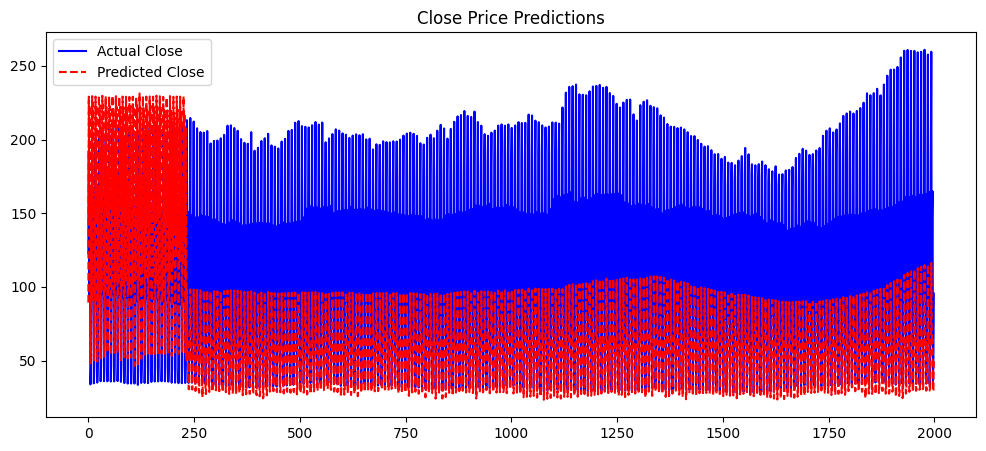

In [49]:
import matplotlib.pyplot as plt
actuals = actuals.astype(float)

plt.figure(figsize=(12, 5))
plt.plot(actuals[:, 2], label="Actual Close", color="blue")
plt.plot(preds[:, 2], label="Predicted Close", color="red", linestyle="dashed")
plt.legend()
plt.title("Close Price Predictions")
plt.show()